In [1]:
import velocyto as vcy
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/global/home/hpc3837/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This script is largely a copy of the [Dentate Gyrus Example Notebook](https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb) with a few small tweaks--notably constraining groups during kNN imputation to deal with issues that could arise from using data aggregated from different conditions

# Load the data

In [2]:
vlm = vcy.VelocytoLoom('EMT_timecourse_filtered.loom')

# Define clusters for downstream analysis

In [3]:
colors_dict = {'Control': np.array([ 0.2,  0.53,  0.71]), 'TGFB_1d': np.array([ 0.95,  0.6,  0.1]),
               'TGFB_3d': np.array([ 0.1,  0.45,  0.3]), 'TGFB_7d': np.array([ 0.8,  0.02,  0.1])}
vlm.set_clusters(vlm.ca["Treatment"], cluster_colors_dict=colors_dict)

# Filtering and normalization

In [4]:
# This is called just to compute the initial cell size, normalized value will be recalculated
vlm.normalize("S", size=True,  log=False)
vlm.normalize("U", size=True,  log=False)

In [5]:
vlm.score_detection_levels(min_expr_counts=50, min_cells_express=25)
vlm.filter_genes(by_detection_levels=True)

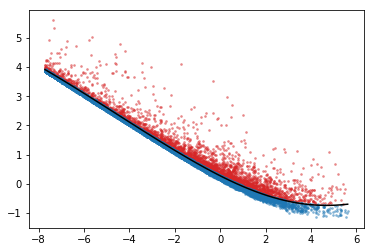

In [6]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [7]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total()
vlm.adjust_totS_totU(normalize_total=True)

# Fit models

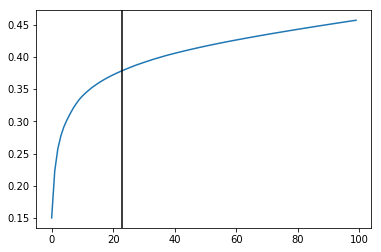

In [8]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")

Because the data is aggregated across a time course experiment, the data violates the assumption that all cells are from the same biological condition. In this situation, we may have cells with the same gene expression program, but different underlying dynamics. This is problematic for kNN imputation. To deal with this, we'll use the group_constraint option below, limiting the kNN determination to cells within the same cluster (ie. condition).

The default value for k in this function is 0.025\*n_cells, but because we're constraining it to each cluster, I'll use k=75, which is around 0.025\*cluster size

In [9]:
k=75
vlm.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*5, b_maxl=k*3, 
                   group_constraint="clusters", n_jobs=8)

In [10]:
vlm.normalize_median()
vlm.fit_gammas(limit_gamma=True)

Remove genes with irregular phase portraits with filter_genes_good_fit()

In [11]:
vlm.filter_genes_good_fit()

# Visualize fits
I just picked 12 genes that passed filter--some arbitrary, some with known relevant to EMT 

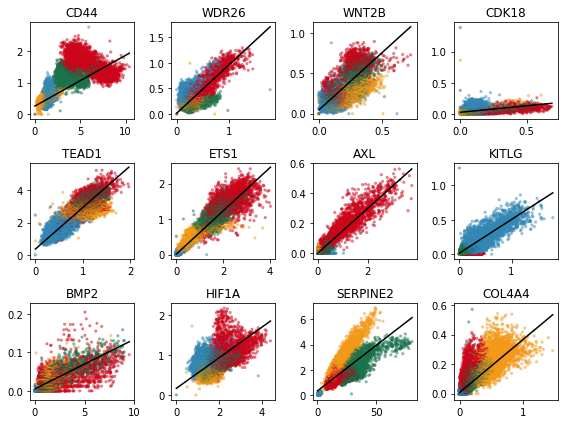

In [12]:
plt.figure(None, (8,6))
gs = plt.GridSpec(3,4)
for i, gn in enumerate(["CD44", "WDR26", "WNT2B","CDK18", 'TEAD1', "ETS1", "AXL", "KITLG", "BMP2", "HIF1A", "SERPINE2", "COL4A4"]):
    plt.subplot(gs[i])
    ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=5, alpha=0.4)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
plt.tight_layout()

# Calculate velocity

In [13]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1)

In [17]:
vlm.pcs[:,0]

array([ 18.41841791,  18.83357465,  16.96922036, ..., -12.53519694,
        -2.13403193, -12.30950182])

Just setting up the embeddings I may want to use. Primarily using diffusion map, but will include PCs just in case

In [18]:
vlm.pc = np.column_stack([vlm.pcs[:,0], vlm.pcs[:,1]])
vlm.dc = np.column_stack([vlm.ca["DC1"], vlm.ca["DC2"]])
vlm.dc3 = np.column_stack([vlm.ca["DC2"], vlm.ca["DC3"]])

# Visualize velocity on diffusion map embedding

In [23]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="dc", transform="sqrt",
                             n_neighbors=4000, knn_random=True, sampled_fraction=1)
vlm.calculate_embedding_shift(sigma_corr = 0.05)

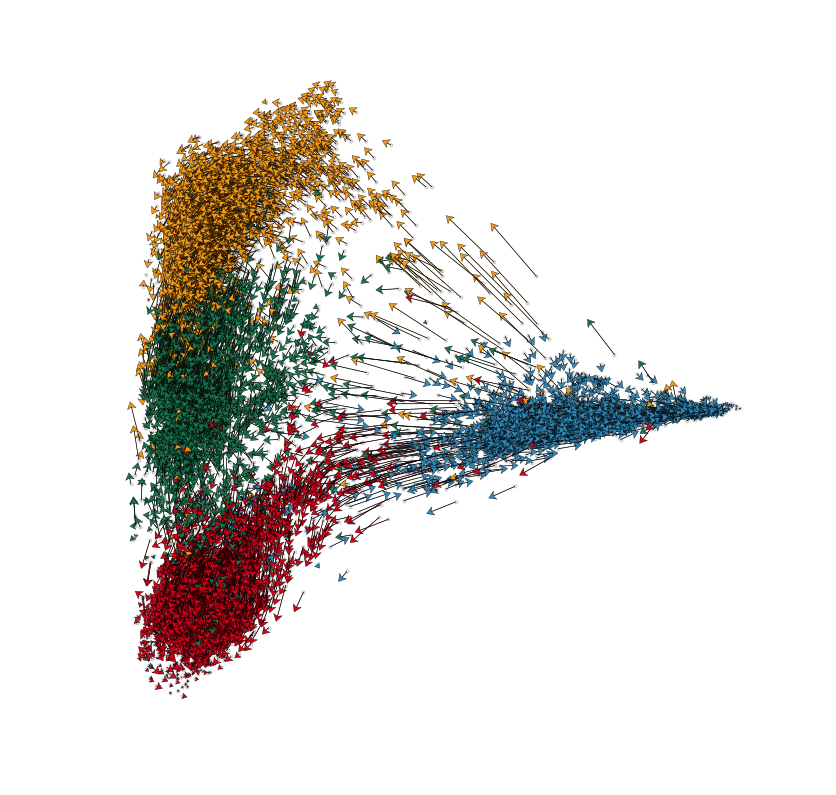

In [24]:
plt.figure(None,(14,14))
quiver_scale = 15

plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1],
            c="0.8", alpha=0.2, s=20, edgecolor="")

ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3)

quiver_kwargs=dict(headaxislength=15, headlength=20, headwidth=25,linewidths=0.35, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")
plt.savefig("emt_velocity_allcells.png")

## Plotting the conditions separately

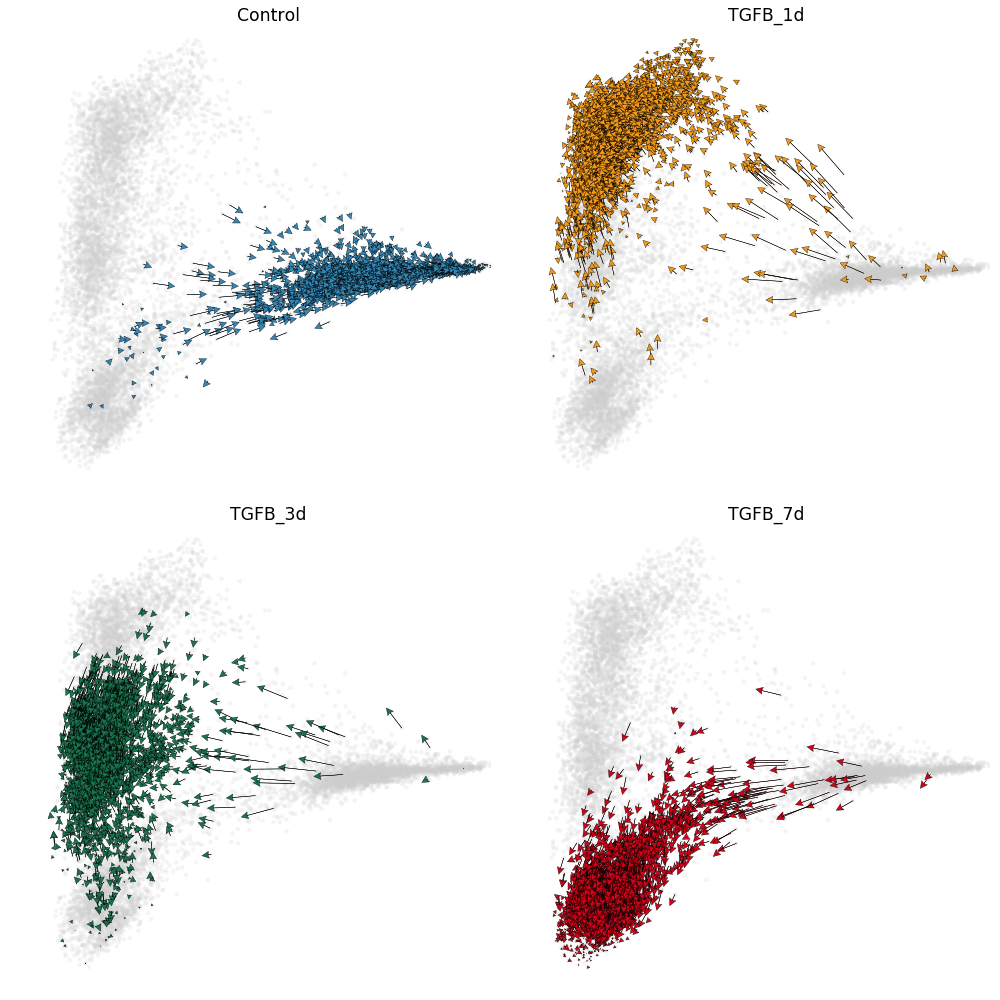

In [31]:
plt.figure(None, (14,14))
gs = plt.GridSpec(2,2)
for i, t in enumerate(["Control", "TGFB_1d", "TGFB_3d", "TGFB_7d"]):
    quiver_scale = 15
    treat_index = np.where(vlm.ca['Treatment'] == t)[0]
    treat_index = np.random.choice(treat_index, size=int(treat_index.shape[0]), replace=False)
    
    plt.subplot(gs[i])
    plt.title(t, size='xx-large')
    
    plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1], c="0.8", alpha=0.2, s=20, edgecolor="")
    
    ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
    quiver_kwargs=dict(headaxislength=30, headlength=35, headwidth=35,linewidths=0.35, width=0.00045,edgecolors="k", color=vlm.colorandum[treat_index], alpha=1)
    plt.quiver(vlm.embedding[treat_index, 0], vlm.embedding[treat_index, 1],
           vlm.delta_embedding[treat_index, 0], vlm.delta_embedding[treat_index, 1],
           scale=quiver_scale, **quiver_kwargs)
    
    plt.axis("off")
    plt.xlim(-0.012,0.023) 
    plt.ylim(-0.022,0.025)
plt.tight_layout()
plt.savefig("emt_velocity_separate_conditions.png")

In [26]:
def plotVelocity (t):
    plt.figure(None, (14,14))
    quiver_scale = 15
    treat_index = np.where(vlm.ca['Treatment'] == t)[0]
    treat_index = np.random.choice(treat_index, size=int(treat_index.shape[0]), replace=False)
    
    plt.scatter(vlm.embedding[:, 0], vlm.embedding[:, 1], c="0.8", alpha=0.25, s=50, edgecolor="")
    
    ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
    quiver_kwargs=dict(headaxislength=30, headlength=35, headwidth=35,linewidths=0.5, width=0.00045,edgecolors="k", color=vlm.colorandum[treat_index], alpha=1)
    plt.quiver(vlm.embedding[treat_index, 0], vlm.embedding[treat_index, 1],
           vlm.delta_embedding[treat_index, 0], vlm.delta_embedding[treat_index, 1],
           scale=quiver_scale, **quiver_kwargs)
    
    plt.axis("off")
    plt.xlim(-0.012,0.023) 
    plt.ylim(-0.022,0.025)
    plt.savefig("emt_velocity_%s.png" % t)

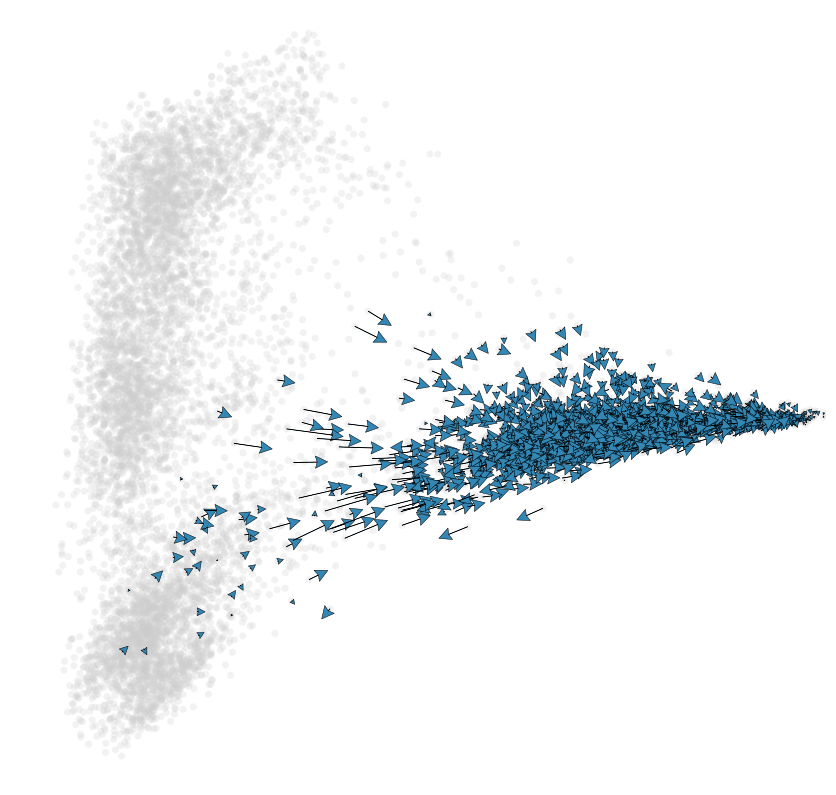

In [27]:
plotVelocity("Control")

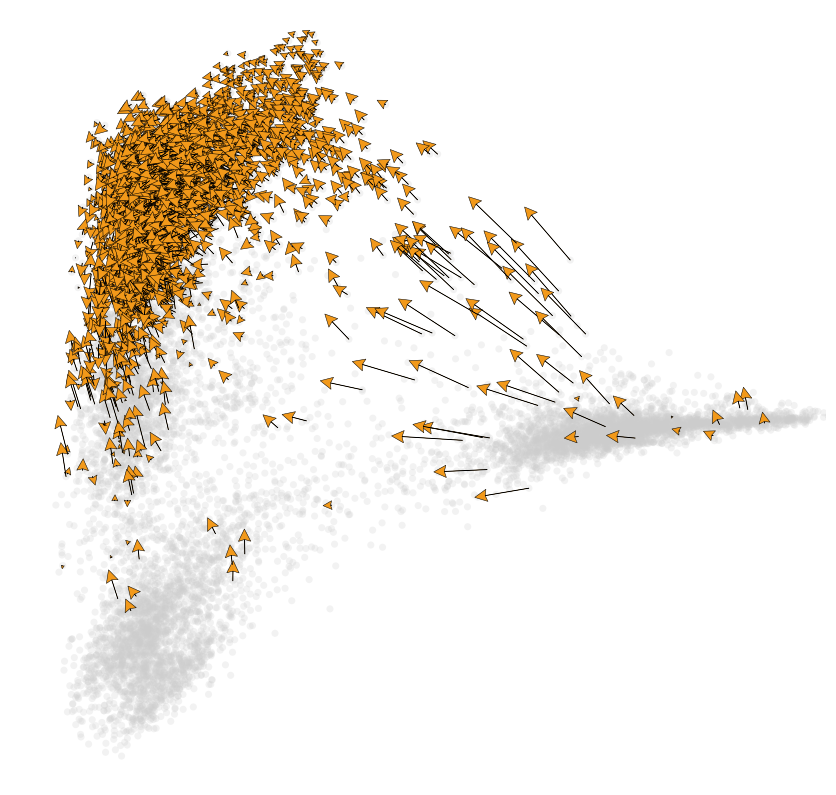

In [28]:
plotVelocity("TGFB_1d")

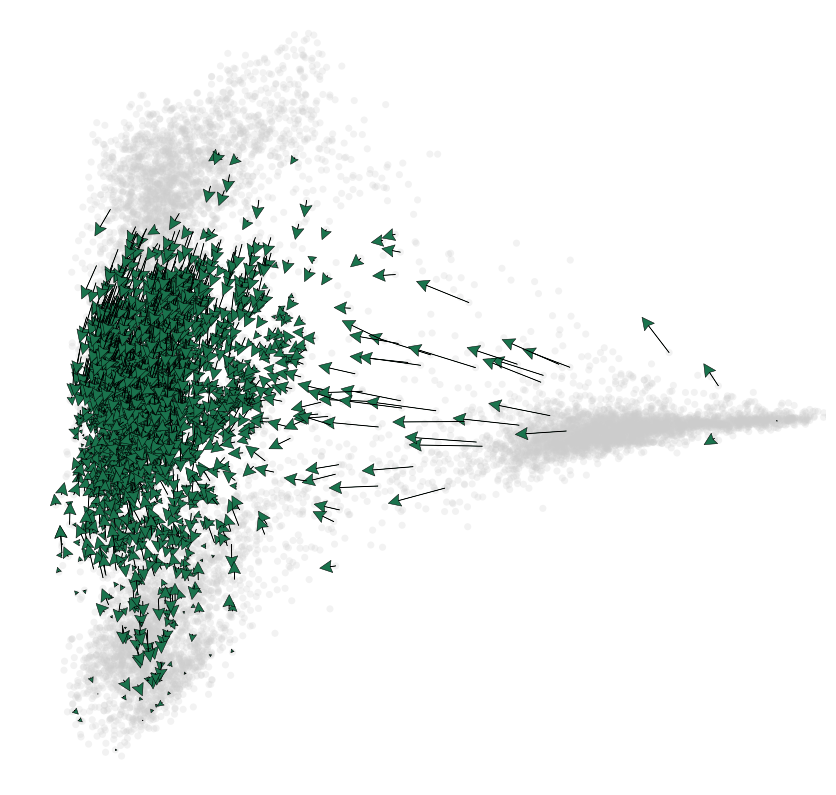

In [29]:
plotVelocity("TGFB_3d")

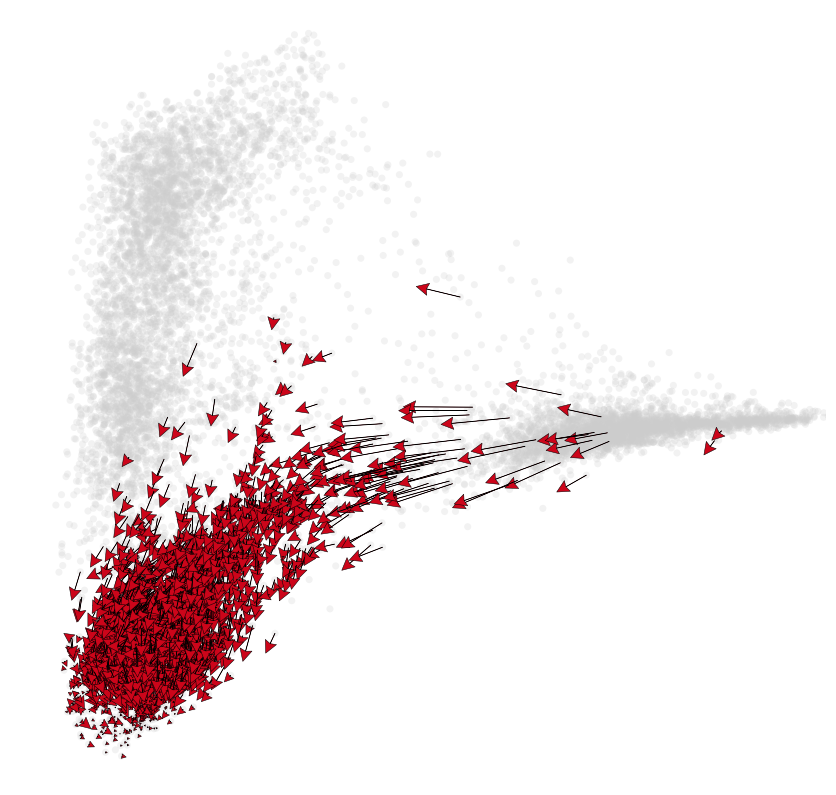

In [30]:
plotVelocity("TGFB_7d")